In [27]:
import sys
import pickle
import glob
import os
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt
import qubic
from qubic import AnalysisMC as amc
from qubic import QubicSkySim as qss
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

thedir = '/home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_100_143_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_217_353_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/cmb_d0_fullHFI_planck_parametric_d0_two'
# thedir = '/home/nahue-ofi/heavy-data/realistic_in_cmb_d1_s0_out_cmb_d1_parametric_d1_two'
# thedir = '/home/nahue-ofi/heavy-data/forecast_inCMBDustSync_outCMBDustSync_advancedparametric_d0_two'

dic_name = '*file*'
realizations = np.sort(glob.glob(thedir + '/' + dic_name))

for i in range(len(realizations)):
    print(i, realizations[i])

nreals = len(realizations)

0 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400820_k299.pkl
1 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400821_k299.pkl
2 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400822_k299.pkl
3 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400823_k299.pkl
4 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400824_k299.pkl
5 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400825_k299.pkl
6 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400826_k299.pkl
7 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400827_k299.pkl
8 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400828_k299.pkl
9 /home/nahue-ofi/heavy-data/cmb_d0_30_44_70_planck_parametric_d0_two/file_seed1_3400829_k299.pkl
10 /home/nahue-ofi/h

In [28]:
def noise_analysis_qubicpatch(map_file,constant_spectral_index=True,nbins_ring=25):
    
    map_dict = pickle.load(open(map_file,'rb'))
    
    if constant_spectral_index:
        ncomps_out = map_dict['components_i'].shape[0]
        ncomps_in = map_dict['components'].shape[0]
        npix_tot = map_dict['components_i'].shape[1]
        nstokes = map_dict['components_i'].shape[2]
        comp_in = map_dict['components']
        comp_out = map_dict['components_i']
        noise = comp_out - comp_in[:ncomps_out,:,:]
        seenpix = map_dict['seenpix']
    else:
        ncomps_out = map_dict['components_i'].shape[2]
        ncomps_in = map_dict['components'].shape[2]
        npix_tot = map_dict['components_i'].shape[1]
        nstokes = map_dict['components_i'].shape[0]
        comp_in = map_dict['components'].T
        comp_out = map_dict['components_i'].T
        noise = comp_out - comp_in[:ncomps_out,:,:]
        seenpix = map_dict['seenpix']
    
    comp_out_qubicpatch = comp_out[:,map_dict['seenpix'],:]
    comp_in_qubicpatch = comp_in[:,map_dict['seenpix'],:]
    noise_qubicpatch = noise[:,map_dict['seenpix'],:]

    center = map_dict['center']
    center_equ = map_dict['center']#[0,-57]
    center_gal = qubic.equ2gal(center_equ[0], center_equ[1])
    
    nside = hp.npix2nside(npix_tot)
    pixsnum_seenpix = np.where(seenpix)[0]
    centralpix = hp.ang2pix(nside, center_gal[0],center_gal[1],lonlat=True)
    angmax= np.max(qss.get_angles(centralpix,pixsnum_seenpix,nside))
    
    angs_int_d0,I_int_d0,Q_int_d0,U_int_d0,dI_int_d0,dQ_int_d0,dU_int_d0 = get_angular_profile(noise[1,:,:],thmax=angmax,nbins=1,doplot=False,allstokes=True,separate=True,integrated=True,center=center)
    angs_int_cmb,I_int_cmb,Q_int_cmb,U_int_cmb,dI_int_cmb,dQ_int_cmb,dU_int_cmb = get_angular_profile(noise[0,:,:],thmax=angmax,nbins=1,doplot=False,allstokes=True,separate=True,integrated=True,center=center)

    noise_angular_circles = np.array([[angs_int_cmb,I_int_cmb,Q_int_cmb,U_int_cmb,dI_int_cmb,dQ_int_cmb,dU_int_cmb],[angs_int_d0,I_int_d0,Q_int_d0,U_int_d0,dI_int_d0,dQ_int_d0,dU_int_d0]])
    
    angs_d0,dI_d0,dQ_d0,dU_d0 = qss.get_angular_profile(noise[1,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center)
    angs_cmb,dI_cmb,dQ_cmb,dU_cmb = qss.get_angular_profile(noise[0,:,:],thmax=30,nbins=nbins_ring,doplot=False,allstokes=True,separate=True,center=center)

    noise_angular_rings = np.array([[angs_cmb,dI_cmb,dQ_cmb,dU_cmb],[angs_d0,dI_d0,dQ_d0,dU_d0]])
    
    return comp_out_qubicpatch, comp_in_qubicpatch, noise_qubicpatch, noise_angular_circles, noise_angular_rings

In [29]:
sys.path.insert(1,"/home/nahue-ofi/CMM-Pipeline/src")

from simtools.analysis import get_angular_profile

In [33]:
constant_spectral_index = True
nbins_ring = 25
angs_cmb = np.zeros((nreals,nbins_ring))
dQ_cmb = np.zeros((nreals,nbins_ring))
dU_cmb = np.zeros((nreals,nbins_ring))
angs_dust = np.zeros((nreals,nbins_ring))
dQ_dust = np.zeros((nreals,nbins_ring))
dU_dust = np.zeros((nreals,nbins_ring))

dQ_cmb_int = np.zeros(nreals)
dU_cmb_int = np.zeros(nreals)
dQ_dust_int = np.zeros(nreals)
dU_dust_int = np.zeros(nreals)

for i,map_file in enumerate(realizations):
    comp_out_qubicpatch, comp_in_qubicpatch, noise_qubicpatch, noise_angular_circles, noise_angular_rings = noise_analysis_qubicpatch(map_file,constant_spectral_index=constant_spectral_index,nbins_ring=nbins_ring)
    angs_cmb[i,:] = noise_angular_rings[0,0]
    dQ_cmb[i,:] = noise_angular_rings[0,2]
    dU_cmb[i,:] = noise_angular_rings[0,3]
    angs_dust[i,:] = noise_angular_rings[1,0]
    dQ_dust[i,:] = noise_angular_rings[1,2]
    dU_dust[i,:] = noise_angular_rings[1,3]
    
    dQ_cmb_int[i] = noise_angular_circles[0,5]
    dU_cmb_int[i] = noise_angular_circles[0,6]
    dQ_dust_int[i] = noise_angular_circles[1,5]
    dU_dust_int[i] = noise_angular_circles[1,6]
    
    

/tmp/ipykernel_11797/1594471723.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dQ_cmb_int[i] = noise_angular_circles[0,5]
/tmp/ipykernel_11797/1594471723.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dU_cmb_int[i] = noise_angular_circles[0,6]
/tmp/ipykernel_11797/1594471723.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dQ_dust_int[i] = noise_angular_circles[1,5]
/tmp/ipykernel_11797/1594471723.py:27: DeprecationWarning: Conversion of an array wi

Text(0, 0.5, 'RMS noise')

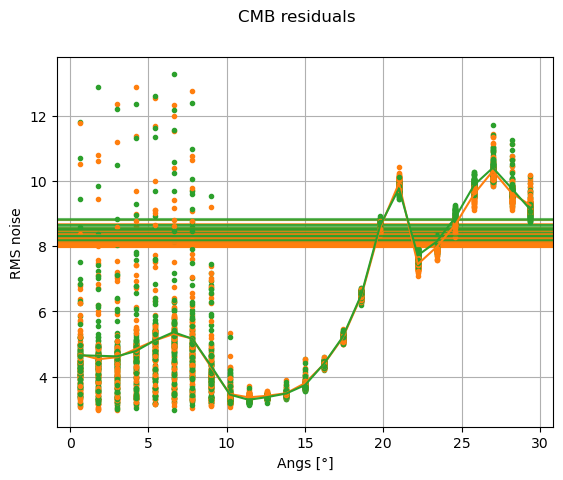

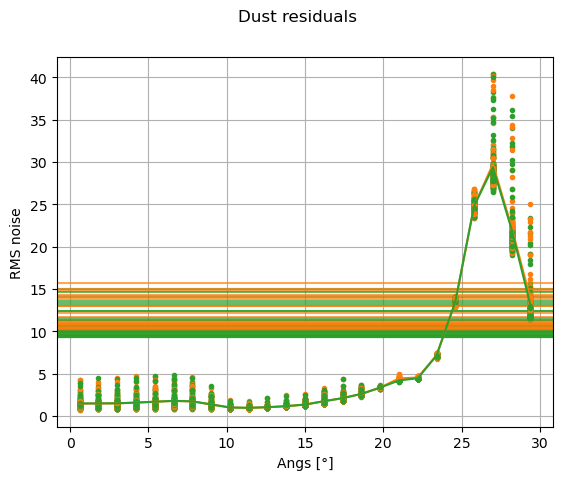

In [34]:
plt.figure()
for i in range(len(realizations)):
    # plt.plot(angs_cmb[i,:],dI_cmb[i,:],'.',c='C0')
    plt.plot(angs_cmb[i,:],dQ_cmb[i,:],'.',c='C1')
    plt.plot(angs_cmb[i,:],dU_cmb[i,:],'.',c='C2')
    plt.axhline(dQ_cmb_int[i],c='C1', alpha = 0.7)
    plt.axhline(dU_cmb_int[i],c='C2', alpha = 0.7)
# plt.plot(angs_cmb[0,:],np.mean(dI_cmb,axis=0),c='C0')
plt.plot(angs_cmb[0,:],np.mean(dQ_cmb,axis=0),c='C1')
plt.plot(angs_cmb[0,:],np.mean(dU_cmb,axis=0),c='C2')
plt.suptitle('CMB residuals')
plt.grid()
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise')

plt.figure()
for i in range(len(realizations)):
    # plt.plot(angs_dust[i,:],dI_dust[i,:],'.',c='C0')
    plt.plot(angs_dust[i,:],dQ_dust[i,:],'.',c='C1')
    plt.plot(angs_dust[i,:],dU_dust[i,:],'.',c='C2')
    plt.axhline(dQ_dust_int[i],c='C1', alpha = 0.7)
    plt.axhline(dU_dust_int[i],c='C2', alpha = 0.7)
# plt.plot(angs_dust[0,:],np.mean(dI_dust,axis=0),c='C0')
plt.plot(angs_dust[0,:],np.mean(dQ_dust,axis=0),c='C1')
plt.plot(angs_dust[0,:],np.mean(dU_dust,axis=0),c='C2')
plt.suptitle('Dust residuals')
plt.grid()
plt.xlabel('Angs [°]')
plt.ylabel('RMS noise')